In [28]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

Cargamos el template:

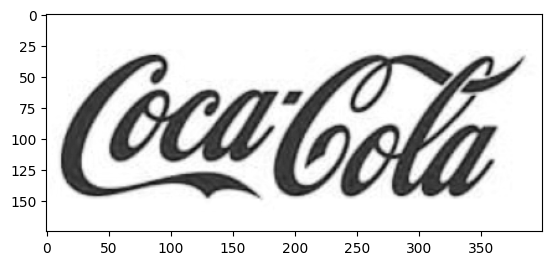

In [29]:
# Cargamos el template
template = cv.imread('template/pattern.png',0)
plt.figure()
plt.imshow(template, cmap='gray')

Cargo las imagenes de la carpeta:

In [30]:
#Importo las imagenes
PATH='./images/'
images = [cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB) for file in glob.glob(PATH+'*.png')]

Luego vamos a definir la funcion de resize. En escencia es wrapper de la funcion de OpenCV.


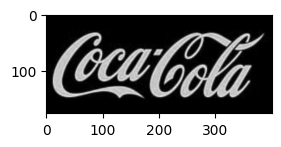

In [31]:
#Definimos la funcion de resize
def resize(template,per=100, n = False):
    '''
    Función para redimensionar una imagen.

    Parámetros:
        template: La imagen original.
        per: El porcentaje de redimensionamiento. Por defecto, 100 (sin redimensionamiento).
        n: Si es True, se aplica la operación bitwise_not a la imagen redimensionada y se invierte

    Devuelve:
        La imagen redimensionada.
    '''
    scale_percent = per
    width = int(template.shape[1] * scale_percent / 100)
    height = int(template.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    # resize image
    resized = cv.resize(template, dim, interpolation = cv.INTER_AREA)
    if n:
        resized=cv.bitwise_not(resized)
    return resized

#Procedemos a alterar el tamaño y principalmente invertir la imagen, dado a que pareceria por lo que se ve en las imagenes que es lo que mas tiene sentido
template=resize(template,per=100, n = True)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')

Vamos a crear varias pramides gaussianas que eventualmente podriamos utilizar mas adelante como template

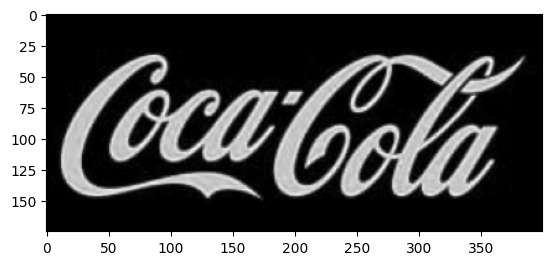

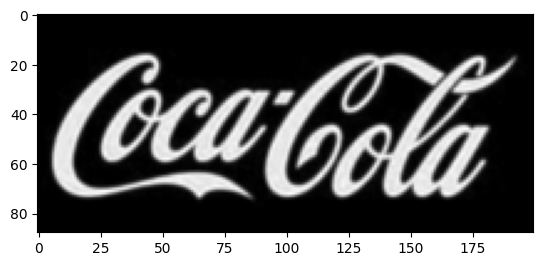

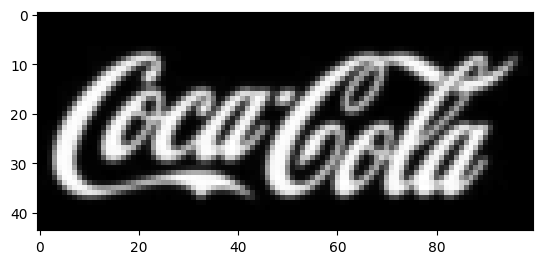

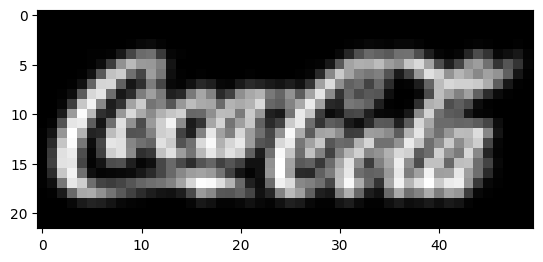

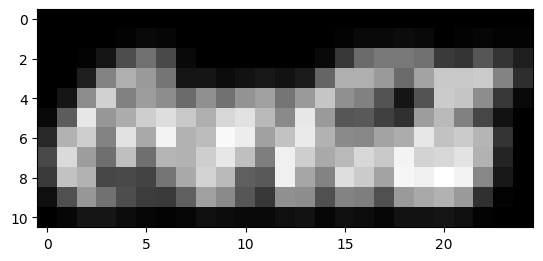

In [32]:
#Applicamos una piramide gaussiana para abajo
#Nivel 1
img_nivel_1 = cv.pyrDown(template)
#Nivel 2
img_nivel_2 = cv.pyrDown(img_nivel_1)
#Nivel 3
img_nivel_3 = cv.pyrDown(img_nivel_2)
#Nivel 4
img_nivel_4 = cv.pyrDown(img_nivel_3)
# Mostramos los resultados
plt.imshow(template,cmap='gray')
plt.show()
plt.imshow(img_nivel_1,cmap='gray')
plt.show()
plt.imshow(img_nivel_2,cmap='gray')
plt.show()
plt.imshow(img_nivel_3,cmap='gray')
plt.show()
plt.imshow(img_nivel_4,cmap='gray')
plt.show()

Asi mismo vamos a crear varias pramides laplacianas con el mismo proposito

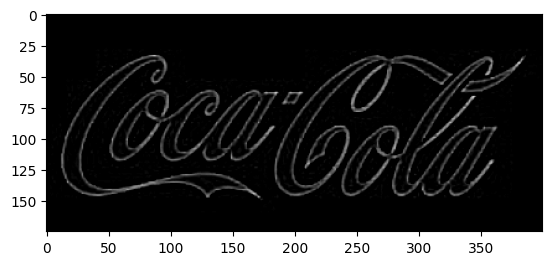

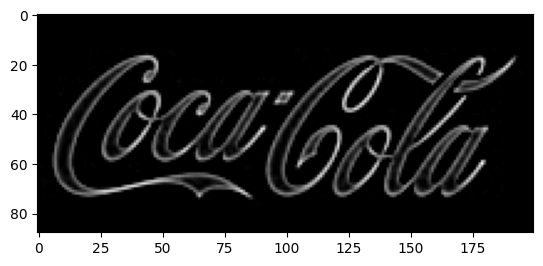

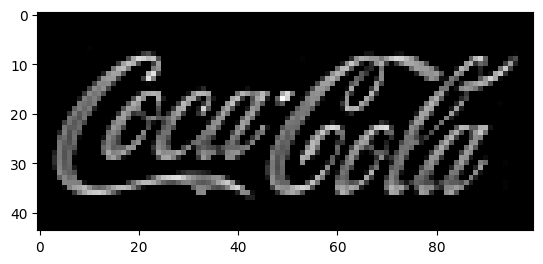

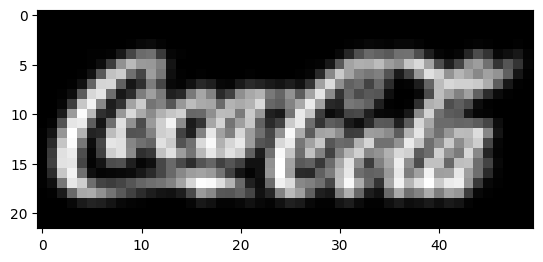

In [33]:
#Applicamos una piramide laplaciana para abajo

# Creamos la pirámide Gaussiana
base = template.copy()
piramide_gauss = [base]
for i in range(3):
    base = cv.pyrDown(base)
    piramide_gauss.append(base)

# Establecemos el último nivel de la Gaussiana en el mismo lugar en la Laplaciana
punta_laplaciana = piramide_gauss[-1]

# Creamos la pirámide Laplaciana
piramide_laplace = [punta_laplaciana]
for i in range(3,0,-1):
    size = (piramide_gauss[i - 1].shape[1], piramide_gauss[i - 1].shape[0])
    gaussiana_expandida = cv.pyrUp(piramide_gauss[i], dstsize=size)
    laplaciana = cv.subtract(piramide_gauss[i-1], gaussiana_expandida)
    piramide_laplace.append(laplaciana)
    cv.imshow('nivel-{}'.format(i-1),laplaciana)

plt.imshow(piramide_laplace[3],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[2],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[1],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[0],cmap='gray')
plt.show()


Ahora si, vamos a proceder con el template matching para cada una de las imagenes de la consigna.

Imagen: 1
Ajuste de tamaño del template (porcentual): 80


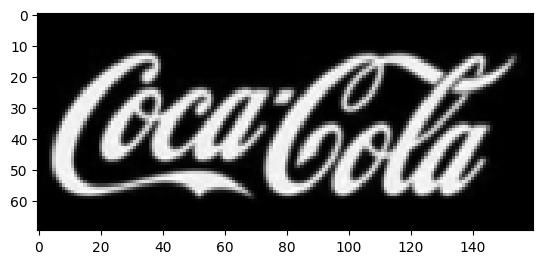

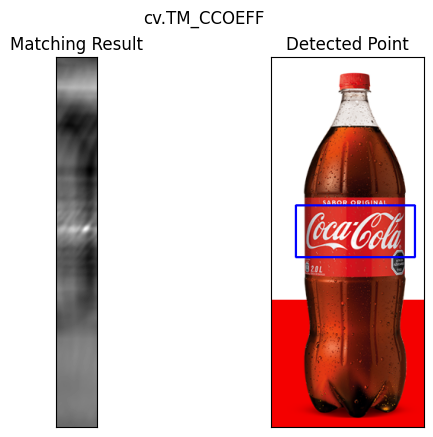

Imagen: 2
Ajuste de tamaño del template (porcentual): 130


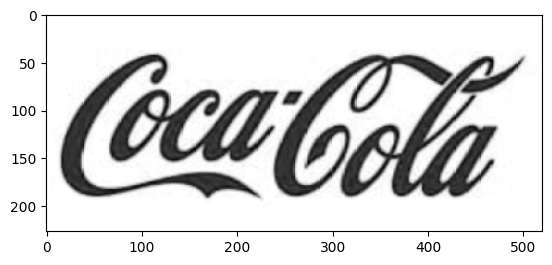

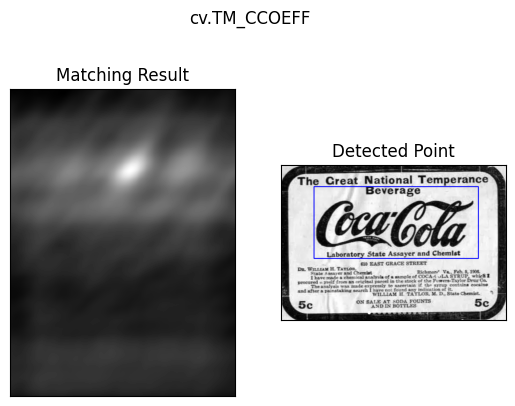

Imagen: 3
Ajuste de tamaño del template (porcentual): 80


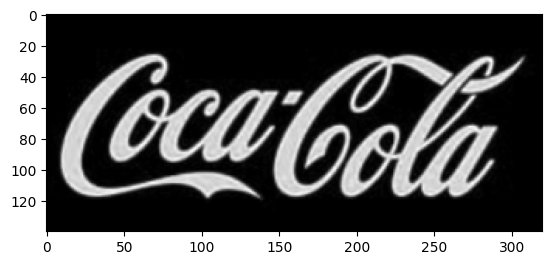

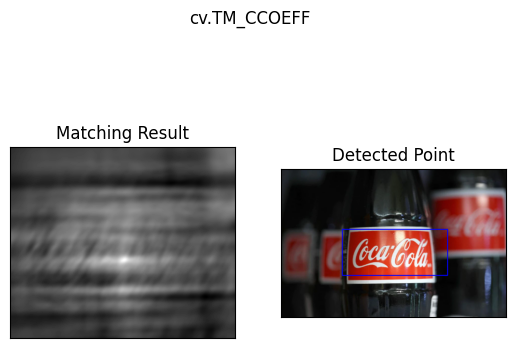

Imagen: 4
Ajuste de tamaño del template (porcentual): 57


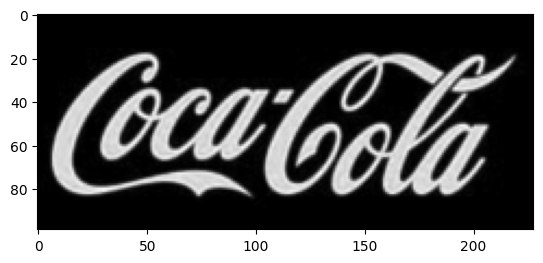

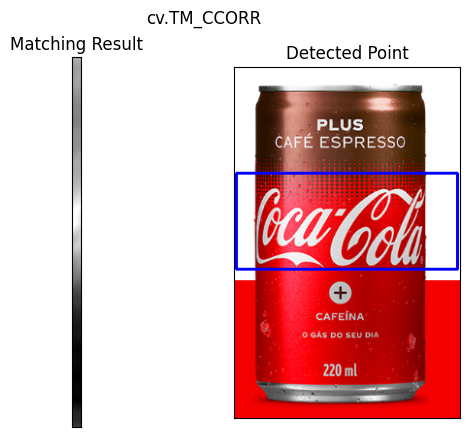

Imagen: 5
Ajuste de tamaño del template (porcentual): 40


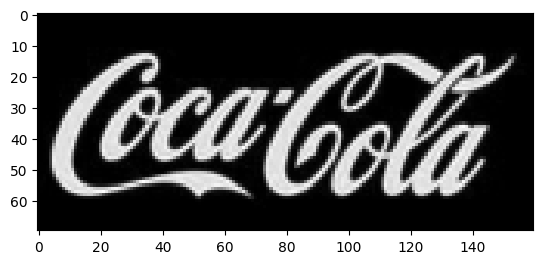

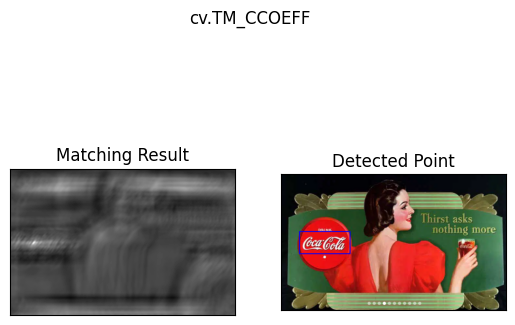

In [34]:
#Hiper parametros:

#Definimos el método a utilizar para cada imagen
meth = [0,'cv.TM_CCOEFF','cv.TM_CCOEFF','cv.TM_CCOEFF','cv.TM_CCORR','cv.TM_CCOEFF']
#Definimos el template a utilizar, o si utilizamos algunas de las piramides construidas previamente
template_=[0,img_nivel_1,template,template,template,template]
#Definimos el resize final del template
size=[0,80,130,80,57,40]
#Definimos si queremos invertirlo o no al template
inverted=[False,False,True,False,False,False]

for index,img in enumerate(images):
    if index==0:
        #La primer imagen es la del ejercicio 2, asi que la salteo
        continue
    # Hago una copia de la imagen
    img_salida = img.copy()
    # La tomo a escala de grises para poder aplicar los filtros
    img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
    # Defino el metodo a utilizar por template matching
    method = eval(meth[index])
    # Ajustamos el tamaño del template para que encaje de manera correcta con cada imagen. También invertimos el template si aplica
    template__=resize(template_[index],per=size[index],n=inverted[index])
    #Obtenemos el tamaño del template
    w, h = template__.shape[::-1]
    #Hacemos el template matching, por las dudas tratamos de capturar las excepciones
    try:
        res = cv.matchTemplate(img_gray, template__, method)
    except:
        print("Size exception")
        #En caso de que haya un problema de size, que los ha habido antes de optimizar los tamaños del template, seguimos el loop
        continue
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    # Dado a que no usamos ni el método TM_SQDIFF ni TM_SQDIFF_NORMED, tomamos el máximo
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # Graficamos el procesamiento y la salida
    print("Imagen:",index)
    print("Ajuste de tamaño del template (porcentual):",size[index])
    plt.figure()
    plt.imshow(template__,cmap='gray')
    plt.show()
    cv.rectangle(img_salida,top_left, bottom_right, (0,0,255), 2)
    plt.figure()
    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth[index])
    plt.show()


2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

Plantemos el algoritmo de detecciones multiples paara coca_multi.png con el mismo template

Ajuste de tamaño del template (porcentual): 80


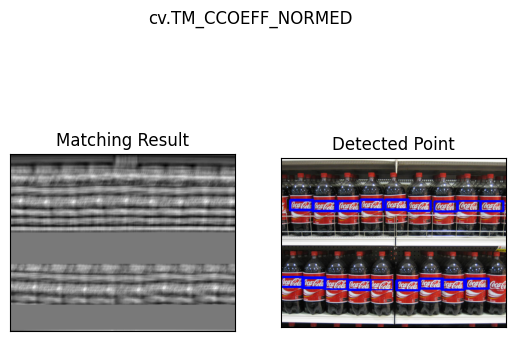

In [35]:
#Definimos este metodo para calcular el tempalte matching
meth = 'cv.TM_CCOEFF_NORMED'
#Definimos el tamaño del template
size=80
#Elegimos la imagen de coca_multi.png
img=images[0]
#Definimos como la template la segunda de la piramide guassiana
template_=img_nivel_2
# Hago una copia de la imagen
img_salida = img.copy()
# Obtengo la imagen en escala de grises
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
# Defino el metodo
method = eval(meth)

# Aplicamos la coincidencia de patrones
#--------------------------------------
template_=resize(template_,per=size,n=False)
w, h = template_.shape[::-1]

try:
    res = cv.matchTemplate(img_gray, template_, method)
except:
    print("Size exception")

# Encontramos los valores máximos y mínimos
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
# Graficamos el procesamiento y la salida
print("Ajuste de tamaño del template (porcentual):",size)

#En base a varios intentos, note que es muy dificil evitar falsos positivos en las estanterias. Esto se debe a que son blancas. Por lo que decidí aplicar una mascara y mandar a 0 las lineas horizontales que corresponden a las bandas
res[250:350,:]=0
res[480:560,:]=0
# Asi mismo decidi aplicar un filtro gaussiano muy pequeño res a modo de reducir el ruido
res = cv.GaussianBlur(res,(3,3),0)

#Defino el theshold para detectar la imagen. Luego de aplicar el filtro, este threshold bajó, y tiene sentido que eso suceda.
threshold = 0.39

#Encontramos los lugares donde se cumple que se pasa el threshold
loc = np.where( res >= threshold)

#Dibujamos los rectangulos
for pt in zip(*loc[::-1]): 
    cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

#Graficamos todo
plt.figure()

# Resultado de coincidencia
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

# Imagen original con recuadros
plt.subplot(122),plt.imshow(img_salida)
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

plt.suptitle(meth)
plt.show()